## Importing Dependencies


In [1]:
## Checking for GPU Access
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import collections
import random
import numpy as np
import os
import time
from tqdm import tqdm
from PIL import Image
import pandas as pd
#Import all the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import keras
from tensorflow.keras.utils import load_img
import string
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from sklearn.utils import shuffle
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Input
!pip install pyyaml h5py  

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import json
from glob import glob
import pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp '/content/drive/MyDrive/kaggle.json' '/content'

## Preparing the Dataets 



In [5]:
import zipfile
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!kaggle datasets download -d nunenuh/flickr30k
zip_ref = zipfile.ZipFile('flickr30k.zip', 'r') 
zip_ref.extractall('/content/tmp') 
zip_ref.close()

100% 8.15G/8.16G [01:46<00:00, 76.0MB/s]
100% 8.16G/8.16G [01:46<00:00, 82.0MB/s]


In [6]:
#Import the dataset and read the text file into a separate variable

text_file = '/content/tmp/captions.txt'

def load_doc(filename):
    
    #your code here
    open_file = open(text_file, 'r', encoding='latin-1' ) #returns a file object
    text = open_file.read() #reads contents of the file
    open_file.close()
    #print(text)
    
    return text

doc = load_doc(text_file)
print(doc[:300])

image_name|caption_number|caption_text
1000092795.jpg|0|Two young guys with shaggy hair look at their hands while hanging out in the yard .
1000092795.jpg|1|Two young , White males are outside near many bushes .
1000092795.jpg|2|Two men in green shirts are standing in a yard .
1000092795.jpg|3|A man


In [7]:
img_path = '/content/tmp/images/'

img_id = [] #store all the image id here
img_vector = [] #store all the image path here
annot = [] 

with open('/content/tmp/captions.txt' , 'r') as fo:
  next(fo) #to skip the heading
  for line in fo :
    split_arr = line.split('|')
    img_id.append(split_arr[0])
    annot.append('<start> ' + split_arr[2].rstrip('\n.') + ' <end>') #removing out the \n.
    img_vector.append(img_path+split_arr[0])

img_id=img_id[:5000]
img_vector=img_vector[:5000]
annot=annot[:5000]

df = pd.DataFrame(list(zip(img_id, img_vector,annot)),columns =['ID','Path', 'Captions']) 

In [8]:
import json

# Load the Flickr30k version of the Karpathy split
with open('/content/drive/MyDrive/Vit+Trans_Flickr/dataset_flickr30k.json', 'r') as f:
    flickr30k_dataset = json.load(f)

full_df= pd.DataFrame()

for image in flickr30k_dataset['images']:
    if image['split'] == 'train' or image['split'] == 'val':
      a=image['filename']
      new_df = df.loc[df['ID'].isin([a])]
      full_df = pd.concat([full_df, new_df], ignore_index=True)

full_df.to_csv('/content/drive/MyDrive/Vit+Trans_Flickr/trainval.csv')

full_df=pd.read_csv('/content/drive/MyDrive/Vit+Trans_Flickr/trainval.csv')
all_img_id=list(full_df['ID'])
all_img_vector=list(full_df['Path'])
annotations=list(full_df['Captions'])

#### Separating Train, Test, Validation data according to Karpathy split

In [9]:
train_df= pd.DataFrame()

for image in flickr30k_dataset['images']:
    if image['split'] == 'train':
      a=image['filename']
      new_df = df.loc[df['ID'].isin([a])]
      train_df = pd.concat([train_df, new_df], ignore_index=True)

train_df.to_csv('/content/drive/MyDrive/Vit+Trans_Flickr/train.csv')

train_df=pd.read_csv('/content/drive/MyDrive/Vit+Trans_Flickr/train.csv')
train_img_id=list(train_df['ID'])
train_img_vector=list(train_df['Path'])
train_annotation=list(train_df['Captions'])

In [10]:
test_df= pd.DataFrame()

for image in flickr30k_dataset['images']:
    if image['split'] == 'test':
      a=image['filename']
      new_df = df.loc[df['ID'].isin([a])]
      test_df = pd.concat([test_df, new_df], ignore_index=True)

test_df.to_csv('/content/drive/MyDrive/Vit+Trans_Flickr/test.csv')

test_df=pd.read_csv('/content/drive/MyDrive/Vit+Trans_Flickr/test.csv')
test_img_id=list(test_df['ID'])
test_img_vector=list(test_df['Path'])
test_annotation=list(test_df['Captions'])

In [11]:
val_df= pd.DataFrame()

for image in flickr30k_dataset['images']:
    if image['split'] == 'val':
      a=image['filename']
      new_df = df.loc[df['ID'].isin([a])]
      val_df = pd.concat([val_df, new_df], ignore_index=True)

val_df.to_csv('/content/drive/MyDrive/Vit+Trans_Flickr/val.csv')

val_df=pd.read_csv('/content/drive/MyDrive/Vit+Trans_Flickr/val.csv')
val_img_id=list(val_df['ID'])
val_img_vector=list(val_df['Path'])
val_annotation=list(val_df['Captions'])

In [12]:
#check total captions and images present in dataset

print(len(test_img_vector)+len(train_img_vector)+len(val_img_vector))
print(len(train_img_vector))
print(len(test_img_vector))
print(len(val_img_vector))
print(len(all_img_vector))

4875
4485
205
185
4670


<start> A man sits in a chair while holding a large stuffed animal of a lion  <end>


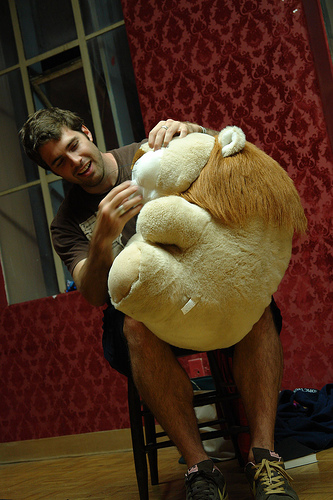

In [13]:
## Sanity check
print(annotations[30])
Image.open(all_img_vector[30])

Currently, `annotations` is an array of captions corresponding with each image in `image_name_vector` which is an array o fimage paths

##Tokenizer

The captions in the `annotations` array are tokenized using the TensorFLow TextVectorizer with tunable hyperparameters. 

In [14]:
caption_dataset1 = tf.data.Dataset.from_tensor_slices(train_annotation)
caption_dataset2 = tf.data.Dataset.from_tensor_slices(val_annotation)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")


top_word_cnt = 3500
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = top_word_cnt+1, filters= '!"#$%^&*()_+.,:;-?/~`{}[]|\=@ ',
                      lower = True, char_level = False, 
                      oov_token = 'UNK')
tokenizer.fit_on_texts(annotations)
tokenizer.fit_on_texts(test_annotation)
tokenizer.fit_on_texts(val_annotation)
train_seqs = tokenizer.texts_to_sequences(annotations)
test_seq = tokenizer.texts_to_sequences(test_annotation)
val_seq = tokenizer.texts_to_sequences(val_annotation)

# we add PAD token for zero
tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'

with open("/content/drive/MyDrive/Vit+Trans_Flickr/tokenizer.pickle", 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)  # hadie

# # Max word count for a caption.
max_length = 50
# Use the top 5000 words for a vocabulary.
vocabulary_size = 3500
token = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
token.adapt(caption_dataset1)
token.adapt(caption_dataset2)

In [15]:
caption_vector_train = caption_dataset1.map(lambda x: token(x))
caption_vector_val = caption_dataset2.map(lambda x: token(x))

In [16]:
import pickle
with open("/content/drive/MyDrive/Vit+Trans_Flickr/tokenizer.pickle", 'rb') as handle: 
  tokenizer = pickle.load(handle)

vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 3953


In [17]:
train_seqs_len = [len(seq) for seq in train_seqs]

#store elements from list with maximum value
longest_word_length = max(train_seqs_len)

# #for train
cap_vector_test= tf.keras.preprocessing.sequence.pad_sequences(test_seq, padding= 'post', maxlen = longest_word_length,
                                                          dtype='int32', value=0)
print("The shape of test Caption vector is :" + str(cap_vector_test.shape))

#for val
cap_vector_val= tf.keras.preprocessing.sequence.pad_sequences(val_seq, padding= 'post', maxlen = longest_word_length,
                                                          dtype='int32', value=0)

print("The shape of val Caption vector is :" + str(cap_vector_val.shape))

The shape of test Caption vector is :(205, 42)
The shape of val Caption vector is :(185, 42)


At the End, while making the predictions, we also have to detokenize the tokens into word sequences for which two layers below are initialized to create mappings for words to indices and indices to words 

`index_to_word` is used to detokenize the tokens while making predictions

In [18]:
# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=token.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=token.get_vocabulary(),
    invert=True)

As of now, the images are in the `image_name_vector` array as image paths. The model requires imagees to be fed as matrices

For this implementation, as the pretrained vision transformer model is used, the vision transformer requires images to be in the dimensions `(batch_size, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)`

For the Vision transformer used:

`IMAGE_SIZE` is 224

In [19]:
## FUnction to load the images into the required format
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(224, 224)(img)
    return img

In [20]:
train_ds = tf.data.Dataset.from_tensor_slices(train_img_vector)
train_ds = train_ds.map(
  load_image)

val_ds = tf.data.Dataset.from_tensor_slices(val_img_vector)
val_ds = val_ds.map(
  load_image)


In [21]:
## Normalizing the images in the dataset to be suitable for the neural network 
def rescale(img):
  return img/255.

train_ds = train_ds.map(rescale)
val_ds = val_ds.map(rescale)

## Initializing the pretrained Vision Transformer

In [22]:
!pip install tensorflow_addons
!pip install --quiet vit-keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [23]:
from vit_keras import vit

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


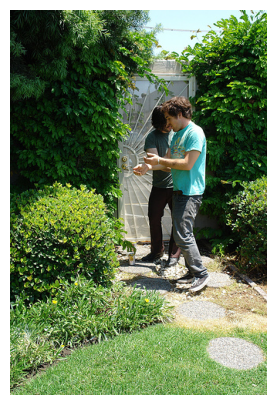

In [24]:
## Image size for the Vision Transformer
IMAGE_SIZE = 224


import matplotlib.pyplot as plt
try_img = plt.imread(all_img_vector[0])
try_img = try_img/255.
plt.figure(figsize = (5, 5))
plt.imshow(try_img)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([try_img]), size=(IMAGE_SIZE, IMAGE_SIZE)
)

For this implementaiton, the Vision transformer vit_b32 is used.

More details on the tensorflow hub website:

https://tfhub.dev/sayakpaul/collections/vision_transformer/1

In [25]:
vit_model = vit.vit_b32(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        )

353253686/353253686 [==============================] - 8s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Instead of classification we need the vision transformer to output a tensor of shape `(batch_size, seq_len, d_model)`

So we use the second to last layer on the vision transformer as the final layer giving the output shape: `shape=(None, 50, 768)`

In [26]:
new_input = vit_model.input
hidden_layer = vit_model.layers[-2].output
## The New Vision Transformer Model with the required output shapes 
vision_transformer_model = tf.keras.Model(new_input, hidden_layer)

In [27]:
## For experimentation, freeze the layers of the pretrained Vision transformer
for layer in vision_transformer_model.layers:
  layer.trainable = False

In [28]:
## Checking the model summary 
vision_transformer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 7, 7, 768)         2360064   
                                                                 
 reshape (Reshape)           (None, 49, 768)           0         
                                                                 
 class_token (ClassToken)    (None, 50, 768)           768       
                                                                 
 Transformer/posembed_input   (None, 50, 768)          38400     
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 50, 768),        7087872   
 (TransformerBlock)           (None, 12, None, None))        

##SWIN

In [29]:
# !pip install tfswin
# from keras import layers, models
# from tfswin import SwinTransformerBase224, preprocess_input

# inputs = layers.Input(shape=(224, 224, 3), dtype='uint8')
# outputs = layers.Lambda(preprocess_input)(inputs)
# outputs = SwinTransformerBase224(include_top=False)(outputs)

# # outputs = layers.Dense(50, activation='softmax')(outputs)

# swin_model = models.Model(inputs=inputs, outputs=outputs)
# for layer in swin_model.layers:
#   layer.trainable = False

## Positional Encodings for the captions

Attention layers see their input as a set of vectors, with no sequential order. This model also doesn't contain any recurrent or convolutional layers. Because of this a "positional encoding" is added to give the model some information about the relative position of the tokens in the sentence.

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of tokens in a sentence. So after adding the positional encoding, tokens will be closer to each other based on the similarity of their meaning and their position in the sentence, in the d-dimensional space.

The formula for calculating the positional encoding is as follows:

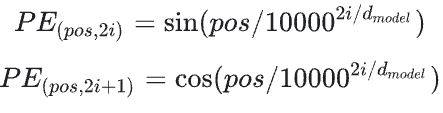

In [30]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [31]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

## Masking the sequences

The sequences are masked to seperate real tokens from paddings, the following create the masks for the tokens

In [32]:
def create_padding_mask(seq, m_slots=None):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
    # Memory slots pads
    if m_slots:
        m_pad = tf.zeros((tf.shape(seq)[0], m_slots))  # (batch_size, m_slots)
        seq = tf.concat([seq, m_pad], axis=1)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [33]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

## Scaled Dot Product Attention

In [34]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead)
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [35]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
    print('Attention weights are:')
    print(temp_attn)
    print('Output is:')
    print(temp_out)

## Multi-Head Attention

In [36]:
class MultiHeadAttentionMemory(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, m_slots):
        super(MultiHeadAttentionMemory, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads
        self.m_slots = m_slots

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        if self.m_slots:
            self.mk, self.mv = self.get_memories(m_slots)

        self.dense = tf.keras.layers.Dense(d_model)
  

    def get_memories(self, m_slots):
        mk = self.add_weight(name="memory_k", 
                            shape=(1, m_slots, self.d_model), 
                            initializer=tf.keras.initializers.RandomNormal(stddev=1/self.d_model))
        mv = self.add_weight(name="memory_v", 
                            shape=(1, m_slots, self.d_model), 
                            initializer=tf.keras.initializers.RandomNormal(stddev=1/self.m_slots))
        return mk, mv

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # ...
        v = self.wv(v)  # ...

        q = self.split_heads(q, batch_size) # (batch_size, num_heads, seq_len, depth)
        k = self.split_heads(k, batch_size)  
        v = self.split_heads(v, batch_size)
    
        if self.m_slots:
            m_k = self.split_heads(self.mk, batch_size=1) # (batch_size, num_heads, memory_slots, depth)
            m_v = self.split_heads(self.mv, batch_size=1) # ...
            k = tf.concat(
              [k, tf.tile(m_k, [batch_size, 1, 1, 1])], axis=2) # (batch_size, num_heads, memory_slots + seq_len_k, depth)
            v = tf.concat(
              [v, tf.tile(m_v, [batch_size, 1, 1, 1])], axis=2) # ...

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k + memory_slots)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
    
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
    
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [37]:
temp_mham = MultiHeadAttentionMemory(d_model=512, num_heads=8, m_slots=40)

y = tf.random.uniform((64, 60, 2048))
sample_mask = create_padding_mask(tf.reduce_sum(y, axis=-1), m_slots=40)

output, attn = temp_mham(y, k=y, q=y, mask=sample_mask)
output.shape, attn.shape

(TensorShape([64, 60, 512]), TensorShape([64, 8, 60, 100]))

## The Encoder Layer 

In [38]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [39]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, m_slots, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttentionMemory(d_model, num_heads, m_slots)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        out1 = self.dropout1(attn_output, training=training) # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [40]:
sample_encoder_layer = EncoderLayer(512, 8, 40, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 20, 2048)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 20, 512])

In [41]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, m_slots, vision_transformer, dff, rate=0.1):
        super(Encoder, self).__init__()
        self.vit = vision_transformer
        self.d_model = d_model
        self.num_layers = num_layers
        self.dense = tf.keras.layers.Dense(self.d_model, activation=tf.nn.gelu)
        self.enc_layers = [EncoderLayer(d_model, num_heads, m_slots, dff, rate)
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)


    def call(self, x, training, mask):
        x = self.vit(x) 
        x = self.dense(x)
        seq_len = tf.shape(x)[1]
        x = self.dropout(x, training=training)
        enc_outputs = []
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
            enc_outputs.append(x)

        return x, enc_outputs  # (batch_size, input_seq_len, d_model)

In [42]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, m_slots=40, vision_transformer=vision_transformer_model, dff=2048)
sample_encoder_output, sample_all_encoder_output = sample_encoder(
    resized_image, False, None
)
sample_encoder_output.shape, sample_all_encoder_output[0].shape

(TensorShape([1, 50, 512]), TensorShape([1, 50, 512]))

## The Decoder

In [43]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, m_slots, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.self_attn = MultiHeadAttentionMemory(d_model, num_heads, m_slots)

        self.enc_attn = MultiHeadAttentionMemory(d_model, num_heads, m_slots)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.fc_alphas = [tf.keras.layers.Dense(d_model) for i in range(num_layers)]

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)


    def call(self, x, enc_outputs, training, look_ahead_mask, padding_mask):
    
        assert len(enc_outputs) == len(self.fc_alphas)

        N = len(enc_outputs)

        # Self-Attention
        self_out, self_attn_weights = self.self_attn(x, x, x, look_ahead_mask)
        self_out = self.dropout1(self_out, training=training)

        mesh_outs = []
        for i in range(N):
            # Cross-Attention between self_out and enc_outputs
            cross_out, cross_attn_weights = self.enc_attn(enc_outputs[i], 
                                                        enc_outputs[i], 
                                                        self_out, 
                                                        padding_mask)
      
            alpha_out = tf.nn.sigmoid(
                self.fc_alphas[i](tf.concat([self_out, cross_out], axis=-1))
            )
            mesh_outs.append(alpha_out * cross_out)
    
        mesh_out = tf.add_n(mesh_outs) / tf.math.sqrt(float(N))
        mesh_out = self.dropout2(mesh_out, training=training)
        mesh_out = self.layernorm1(mesh_out + self_out)
    
        ffn_out = self.ffn(mesh_out)
        ffn_out = self.dropout3(ffn_out, training=training)
        ffn_out = self.layernorm2(ffn_out + mesh_out) # (batch_size, seq_len_q, d_model)

        return ffn_out, self_attn_weights, cross_attn_weights

In [44]:
# Decoder layer don't issue memory slots
sample_decoder_layer = DecoderLayer(num_layers=2, d_model=512, num_heads=8, m_slots=None, dff=2048)
sample_decoder_output, _, _ = sample_decoder_layer(
    tf.random.uniform((1, 30, 2048)), sample_all_encoder_output, False, None, None
)
sample_decoder_output.shape

TensorShape([1, 30, 512])

In [45]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, m_slots, dff, target_vocab_size,
                   maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.decoder_layers = [
          DecoderLayer(num_layers, d_model, num_heads, m_slots, dff, rate) 
          for _ in range(num_layers) 
        ]
        self.dropout = tf.keras.layers.Dropout(rate)

  
    def call(self, x, enc_outputs, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(float(self.d_model))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, self_attn_weights, cross_attn_weights = self.decoder_layers[i](x, enc_outputs, training, 
                                                                              look_ahead_mask, padding_mask)

        return x, self_attn_weights, cross_attn_weights

In [46]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, m_slots=None, dff=2048, 
                         target_vocab_size=8000, maximum_position_encoding=5000)

sample_decoder_output, self_attn, cross_attn = sample_decoder(
    tf.random.uniform((1, 30)), sample_all_encoder_output, False, None, None
)
sample_decoder_output.shape, self_attn.shape, cross_attn.shape

(TensorShape([1, 30, 512]),
 TensorShape([1, 8, 30, 30]),
 TensorShape([1, 8, 30, 50]))

## The Transformer

In [47]:
class M2_Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, m_slots, dff, target_vocab_size, vision_transformer,
               pe_target, rate=0.1):
        super(M2_Transformer, self).__init__()
        self.vision_transformer = vision_transformer

        self.encoder = Encoder(num_layers, d_model, num_heads, m_slots, self.vision_transformer, dff)
        # Decoder didn't use memory slots
        self.decoder = Decoder(num_layers, d_model, num_heads, None, dff, 
                                 target_vocab_size, pe_target)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)


    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output, all_enc_outputs = self.encoder(inp, training, mask=enc_padding_mask)
        dec_output, self_attn, cross_attn = self.decoder(
            tar, all_enc_outputs, training, look_ahead_mask, dec_padding_mask
        )
        final_output = self.final_layer(dec_output) # (batch_size, tar_seq_len, target_vocab_size)

        return final_output


In [48]:
sample_m2_transformer = M2_Transformer(num_layers=2, d_model=512, num_heads=8, m_slots=40, dff=2048,
                                       target_vocab_size=8000, vision_transformer=vision_transformer_model, pe_target=5000)

x = resized_image
y = tf.random.uniform((1, 36))

class manual(tf.keras.layers.Layer):
    def __init__(self, d_model, vision_transformer):
        super(manual, self).__init__()

        self.vit = vision_transformer
        self.d_model = d_model
        self.dense = tf.keras.layers.Dense(self.d_model, activation=tf.nn.gelu)

    def call(self, x):
        x = self.vit(x) 
        x = self.dense(x)
        return x  
  
encd_size = manual(d_model=512,vision_transformer=vision_transformer_model )
enc_size= encd_size(resized_image)

sample_enc_mask = create_padding_mask(tf.reduce_sum(enc_size, axis=-1), m_slots=40)
sample_dec_mask = create_padding_mask(tf.reduce_sum(enc_size, axis=-1), m_slots=None)

sample_final_output = sample_m2_transformer(
    inp=x, 
    tar=y, 
    training=False,
    enc_padding_mask=sample_enc_mask,
    look_ahead_mask=None, 
    dec_padding_mask=sample_dec_mask
)

sample_final_output.shape

TensorShape([1, 36, 8000])

## Hyperparameters:

In [49]:
## Hyperparameters for transformers
num_layers = 8
d_model = 256
m_slots = 40
dff = 2048
BATCH_SIZE = 64
num_heads = 4
dropout_rate = 0.1

## The Optimizer

In [50]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [51]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

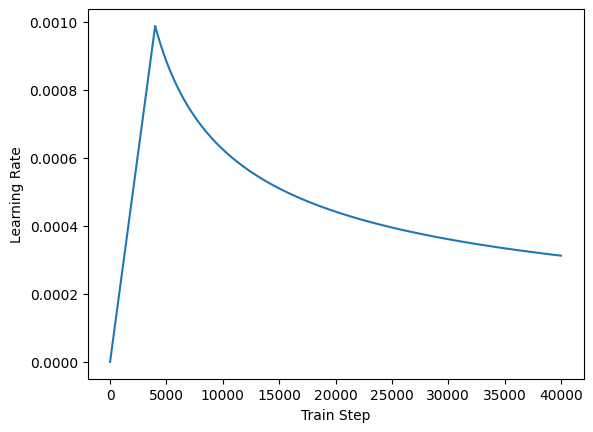

In [52]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

## Loss Metrics

In [53]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [54]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [55]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.Mean(name='val_accuracy')

## Training the Transformer 

In [56]:
m2_transformer = M2_Transformer(num_layers=num_layers, 
                                d_model=d_model, 
                                num_heads=num_heads, 
                                m_slots=m_slots, 
                                dff=dff,
                                target_vocab_size=vocabulary_size, 
                                vision_transformer=vision_transformer_model,
                                pe_target=1000,
                                rate=dropout_rate)

In [57]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp, m_slots=m_slots)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [58]:
checkpoint_path = '/content/drive/MyDrive/Vit+Trans_Flickr/check'

ckpt = tf.train.Checkpoint(transformer=m2_transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
print('Latest checkpoint restored!!', start_epoch)


Latest checkpoint restored!! 18


In [59]:
encd_size = manual(d_model,vision_transformer_model )

In [60]:
@tf.function
def train_step(inp, tar):
    inp_mod= encd_size(inp)

    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    # Remove depth from inp before create mask
    inp_mask = tf.reduce_sum(inp_mod, axis=-1)

    # Create masks
    inp_padding_mask, tar_look_ahead_mask, tar_padding_mask = create_masks(inp_mask, tar_inp)

    with tf.GradientTape() as tape:
        predictions = m2_transformer(inp=inp,
                                     tar=tar_inp,
                                     training=True,
                                     enc_padding_mask=inp_padding_mask,
                                     look_ahead_mask=tar_look_ahead_mask,
                                     dec_padding_mask=tar_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, m2_transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, m2_transformer.trainable_variables))
    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

In [61]:
@tf.function
def val_step(inp, tar):
  inp_mod= encd_size(inp)

  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  inp_mask = tf.reduce_sum(inp_mod, axis=-1)
  inp_padding_mask, tar_look_ahead_mask, tar_padding_mask = create_masks(inp_mask, tar_inp)

  with tf.GradientTape() as tape:
    predictions = m2_transformer(inp=inp,
                                     tar=tar_inp,
                                     training=True,
                                     enc_padding_mask=inp_padding_mask,
                                     look_ahead_mask=tar_look_ahead_mask,
                                     dec_padding_mask=tar_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, m2_transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, m2_transformer.trainable_variables))

  val_loss(loss)
  val_accuracy(accuracy_function(tar_real, predictions))

## Preparing Data for training

In [62]:
train_batches = tf.data.Dataset.zip((train_ds, caption_vector_train))
val_batches = tf.data.Dataset.zip((val_ds, caption_vector_val))
train_batches = train_batches.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_batches = val_batches.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [63]:
for (batch, (inp, tar)) in enumerate(train_batches):
  print(batch)
  print(inp.shape)
  print(tar.shape)
  break

0
(64, 224, 224, 3)
(64, 50)


## Training the Transformer

In [64]:
EPOCHS = 10
ckpt.restore(ckpt_manager.latest_checkpoint)
if ckpt_manager.latest_checkpoint:
  print("Restored from {}".format(ckpt_manager.latest_checkpoint))
else:
  print("Initializing from scratch.")

for epoch in tqdm(range(EPOCHS)):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()
  
  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)
  for (batch, (inp, tar)) in enumerate(val_batches):
    val_step(inp, tar)

  ckpt_save_path = ckpt_manager.save()
  # print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f' Epoch {epoch + 1} Train Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
  print(f' Epoch {epoch + 1} val Loss {val_loss.result():.4f} Accuracy {val_accuracy.result():.4f}')
  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Restored from /content/drive/MyDrive/Vit+Trans_Flickr/check/ckpt-18


 10%|█         | 1/10 [1:07:12<10:04:50, 4032.29s/it]

 Epoch 1 Train Loss 3.2546 Accuracy 0.2707
 Epoch 1 val Loss 4.2330 Accuracy 0.1786
Time taken for 1 epoch: 4032.29 secs



 20%|██        | 2/10 [2:07:07<8:23:20, 3775.03s/it] 

 Epoch 2 Train Loss 3.2073 Accuracy 0.2771
 Epoch 2 val Loss 4.1575 Accuracy 0.1889
Time taken for 1 epoch: 3594.94 secs



 20%|██        | 2/10 [2:15:20<9:01:23, 4060.47s/it]


KeyboardInterrupt: ignored

In [65]:
ckpt.restore(ckpt_manager.latest_checkpoint)
if ckpt_manager.latest_checkpoint:
  print("Restored from {}".format(ckpt_manager.latest_checkpoint))
else:
  print("Initializing from scratch.")

Restored from /content/drive/MyDrive/Vit+Trans_Flickr/check/ckpt-20


## Function to caption the images

In [66]:
from nltk.translate.bleu_score import sentence_bleu
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

def filter(cap):
  cap = ' '.join([str(elem) for elem in cap])
  cap= cap.replace('<start>', "")
  cap= cap.replace('<end>', "")
  cap= cap.replace("b'", "")
  cap= cap.replace("'", "")
  cap=cap[1:]
  return cap

In [67]:
def evaluate(image):
  
  img = plt.imread(image)
  resized_image = tf.image.resize(
    tf.convert_to_tensor([img]), size=(IMAGE_SIZE, IMAGE_SIZE))
  
  ## Scaling the images
  resized_image = resized_image/255.
  ## Initializing the output arrays 
  output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
  output_array = output_array.write(0, [3])
  output = tf.transpose(output_array.stack())
 
  inp_mod= encd_size(resized_image)
  inp_mask = tf.reduce_sum(inp_mod, axis=-1)
 
  for i in tf.range(50):
    output = tf.transpose(output_array.stack())
    
    inp_padding_mask, tar_look_ahead_mask, tar_padding_mask = create_masks(inp_mask, output)

    predictions = m2_transformer(inp=resized_image, tar=output,
                                     training=False,
                                     enc_padding_mask=inp_padding_mask,
                                     look_ahead_mask=tar_look_ahead_mask,
                                     dec_padding_mask=tar_padding_mask)
    predictions = predictions[:, -1:, :]
    predicted_id = tf.argmax(predictions, axis=-1)
    output_array = output_array.write(i+1, predicted_id[0])
    if predicted_id == [4]:
      break
  output = tf.transpose(output_array.stack())
  pred_caption=index_to_word(output)
  return pred_caption

In [68]:
def pred_caption_audio(random, weights=(0.5, 0.5, 0, 0)) :

    cap_test_data = cap_vector_val.copy()
    rid = np.random.randint(0, random)
    test_image = val_img_vector[rid]
    print("test_image" ,test_image)

    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test_data[rid] if i not in [0]])
    real_caption=filt_text(real_caption) 

    pred_caption = evaluate(test_image)
    pred_caption=np.array(pred_caption).tolist()[0]
    pred_caption=filter(pred_caption)

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()

    # score = sentence_bleu(reference, candidate, weights=weights)
    # print(f"BLEU score: {score*100}")
    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
    # plot_attention_map(result, attention_plot, test_image)

    # we will make use of Google Text to Speech API (online), which will convert the caption to audio
    # speech = gTTS('Predicted Caption : ' + pred_caption, lang = 'en', slow = False)
    # speech.save('voice.mp3')
    # audio_file = 'voice.mp3'
    # display.display(display.Audio(audio_file, rate = None, autoplay=False))

    return test_image

In [69]:
def pred_caption_audio1(test_image) :
    pred_caption = evaluate(test_image)    
    pred_caption=np.array(pred_caption).tolist()[0]
    pred_caption=filter(pred_caption)
    # gf.correct(pred_caption)
    print ('Prediction Caption:', pred_caption)
    # plot_attention_map(result, attention_plot, test_image)
    return test_image

test_image /content/tmp/images/1141718391.jpg
Real Caption: a man and a woman are walking across a rope bridge
Prediction Caption: a man in a a bridge bridge bridge bridge bridge 


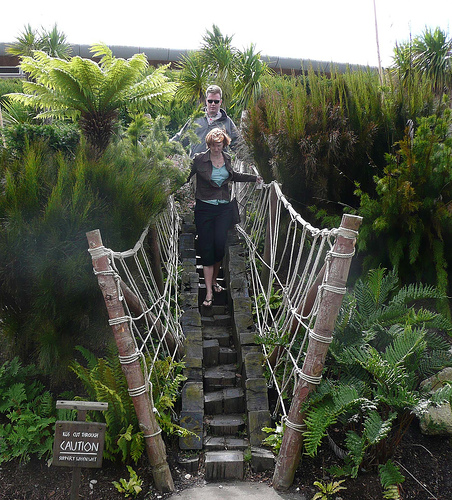

In [85]:
test_image = pred_caption_audio(len(val_img_vector), weights = (0.5, 0.25, 0, 0))
Image.open(test_image)

test_image /content/tmp/images/1206506157.jpg
Real Caption: dogs fight in grass over toy
Prediction Caption: two dogs are in grass grass grass grass 


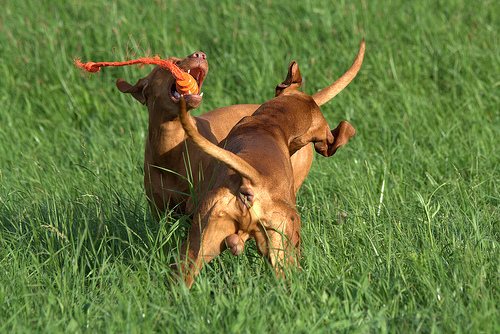

In [86]:
test_image = pred_caption_audio(len(val_img_vector), weights = (0.5, 0.25, 0, 0))
Image.open(test_image)

In [72]:
len(val_img_vector)

185

Prediction Caption: two [UNK] are [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] 


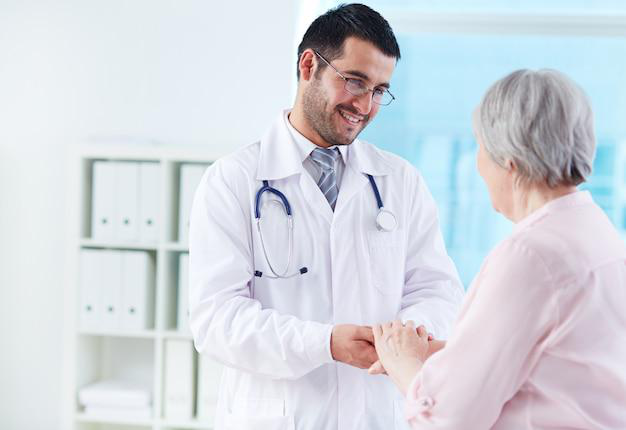

In [77]:
import requests
img_url = "https://img.freepik.com/free-photo/young-doctor-supporting-his-patient_1098-2237.jpg"
im = Image.open(requests.get(img_url, stream=True).raw)
im = im.convert('RGB')
im.save('tmpr.jpg')

test_image = pred_caption_audio1('/content/tmpr.jpg')
Image.open(test_image)

## Evaluation Metrics

In [ ]:
!pip install pycocoevalcap
!pip install pycocotools

In [ ]:
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice

class COCOEvalCap:
    def __init__(self,images,gts,res):
        self.evalImgs = []
        self.eval = {}
        self.imgToEval = {}
        self.params = {'image_id': images}
        self.gts = gts
        self.res = res

    def evaluate(self):
        imgIds = self.params['image_id']
        gts = self.gts
        res = self.res

        # Set up scorers
        # =================================================
        print ('tokenization...')
        tokenizer = PTBTokenizer()
        gts  = tokenizer.tokenize(gts)
        res = tokenizer.tokenize(res)

        # Set up scorers
        # =================================================
        print ('setting up scorers...')
        scorers = [
            (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
            (Meteor(),"METEOR"),
            (Rouge(), "ROUGE_L"),
            (Cider(), "CIDEr"),
            (Spice(), "SPICE")
        ]

        # Compute scores
        # =================================================
        eval = {}
        for scorer, method in scorers:
            print ('computing %s score...'%(scorer.method()))
            score, scores = scorer.compute_score(gts, res)
            if type(method) == list:
                for sc, scs, m in zip(score, scores, method):
                    self.setEval(sc, m)
                    self.setImgToEvalImgs(scs, imgIds, m)
                    print ("%s: %0.3f"%(m, sc))
            else:
                self.setEval(score, method)
                self.setImgToEvalImgs(scores, imgIds, method)
                print ("%s: %0.3f"%(method, score))
        self.setEvalImgs()

    def setEval(self, score, method):
        self.eval[method] = score

    def setImgToEvalImgs(self, scores, imgIds, method):
        for imgId, score in zip(imgIds, scores):
            if not imgId in self.imgToEval:
                self.imgToEval[imgId] = {}
                self.imgToEval[imgId]["image_id"] = imgId
            self.imgToEval[imgId][method] = score

    def setEvalImgs(self):
        self.evalImgs = [eval for imgId, eval in self.imgToEval.items()]

In [ ]:
n=len(test_img_vector)
cap_test_data = cap_vector_test.copy()

def calculate_metrics(rng,datasetGTS,datasetRES):
    imgIds = rng
    gts = {}
    res = {}

    imgToAnnsGTS = {ann['image_id']: [] for ann in datasetGTS['annotations']}
    for ann in datasetGTS['annotations']:
        imgToAnnsGTS[ann['image_id']] += [ann]

    imgToAnnsRES = {ann['image_id']: [] for ann in datasetRES['annotations']}
    for ann in datasetRES['annotations']:
        imgToAnnsRES[ann['image_id']] += [ann]

    for imgId in imgIds:
        gts[imgId] = imgToAnnsGTS[imgId]
        res[imgId] = imgToAnnsRES[imgId]

    evalObj = COCOEvalCap(imgIds,gts,res)
    evalObj.evaluate()
    return evalObj.eval
annotr=[]
annotp=[]


if __name__ == '__main__':
    rng = range(n)
    for j in range(0,n):
      test_image = test_img_vector[j]
      real_caption = ' '.join([tokenizer.index_word[i] for i in cap_vector_test[j] if i not in [0]])   
      pred_caption = evaluate(test_image)
      pred_caption=np.array(pred_caption).tolist()[0]
      pred_caption=filter(pred_caption)
      real_caption=filt_text(real_caption)
      
      datasetGTS={}
      datasetRES={}

      annotr.append({'image_id': j, 'caption': real_caption})
      annotp.append({'image_id': j, 'caption': pred_caption})

    datasetGTS['annotations']=annotr
    datasetRES['annotations']=annotp

    print (calculate_metrics(rng,datasetGTS,datasetRES))
